In [1]:
from random import gauss
import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
sys.path.insert(2,'..')
import functions
import xgboost as xgb
from sklearn import preprocessing
import annualized_rv as arv
from sklearn.model_selection import TimeSeriesSplit


from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
aaplHistIV = pd.read_pickle('historicImpliedVolData/aapl_mean_iv_2017_2022.pkl')
googHistIV = pd.read_pickle('historicImpliedVolData/goog_mean_iv_2017_2022.pkl')
msftHistIV = pd.read_pickle('historicImpliedVolData/msft_mean_iv_2017_2022.pkl')
ndxHistIV = pd.read_pickle('historicImpliedVolData/ndx_mean_iv_2017_2022.pkl')
spyHistIV = pd.read_pickle('historicImpliedVolData/spc_mean_iv_2017_2022.pkl')


In [3]:
spyHistIV.rename(columns = {'date':'Date'},inplace = True) #renaming date column to Date for consistency
spyHistIV.set_index('Date',inplace = True,drop = True) #setting index to date

In [4]:
#grab spy  from yfinance

spyHistory = yf.download('^GSPC', start='2016-01-01', end='2023-12-31')
#calculate realised vol
window =21 #realisedVol window size

spyHistory['DailyReturn'] = np.log(spyHistory['Adj Close']/spyHistory['Adj Close'].shift(1))

spyHistory['21dRealisedVol'] = spyHistory['DailyReturn'].rolling(window=window).std() * np.sqrt(252)


[*********************100%%**********************]  1 of 1 completed


In [6]:
historicIVSeries = spyHistIV['average_iv']
historicVolumeSeries = spyHistory['Volume'].rolling(21).mean()['2017':'2021']
dailyReturnSeries= spyHistory['DailyReturn']['2017':'2021']
dailyRealisedVolSeries = spyHistory['21dRealisedVol']['2017':'2021']


df_combined = pd.concat([historicIVSeries,dailyReturnSeries,dailyRealisedVolSeries,historicVolumeSeries], axis=1)



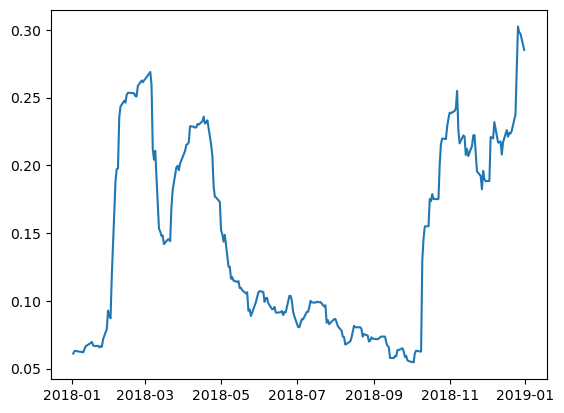

In [8]:
plt.plot(df_combined['21dRealisedVol']['2018':'2018'])


In [9]:
max_pred_length = 1
max_encoder_length = 60


training = TimeSeriesDataSet(
    df_combined,
    time_idx="Date",
    target="average_iv",
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_pred_length,

    time_varying_unknown_reals=["average_iv","Daily Return","21dRealisedVol","Volume"],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

TypeError: TimeSeriesDataSet.__init__() missing 1 required positional argument: 'group_ids'